In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import sys
from timeit import default_timer as timer
np.set_printoptions(threshold=sys.maxsize)

from utils_flatland.optim import Model, training_loop, bruteForce
from utils_flatland.generateData import generateData, generateDataFast
from utils_flatland.helper import computeVisibility, pulse, matchFilt
from utils_flatland.shape import carving

In [2]:
#####################################################################
############################# PARAMETERS ############################
#####################################################################

# laser parameters
numSpots = 75
# las_x = np.linspace(0.5, 1.5, numSpots)
# las_y = 2-las_x # illumination wall 
las_x = 1.25 * np.ones(numSpots)
# las_y = np.linspace(0.25, 1.75)
las_y = np.linspace(2.25, 5.5, numSpots)
usePulse = True
pulseWidth = 1E-9 # only applicable for rectangular pulse

# detector parameters
numPixels = 75
# det_x = np.linspace(-1.5, -0.5, numPixels)
# det_y = 2+det_x # detector wall
det_x = -1.25 * np.ones(numPixels)
# det_y = np.linspace(0.25, 1.75)
det_y = np.linspace(2.25, 5.5, numPixels)
detectorRes = 100E-12 # if this increases, need to subsample pulse

# noise parameters
pctNoise = 0.5
jitter = 600E-12

# optimization parameters
numIters = 3000
thresh = 1E-100
lr_rate = 0.1
lam = 8E4 # 5E2 for noiseless case

# plotting parameters
plotData = False
plotError = True
plotSetup = True

# constant parameters
c = 3E8
    
# miscellaneous parameters
maxDist = (np.max(det_x**2) + np.max(det_y**2))
numBins = np.ceil((maxDist/c) / detectorRes).astype(int)
t = np.linspace(0, detectorRes * numBins, numBins)

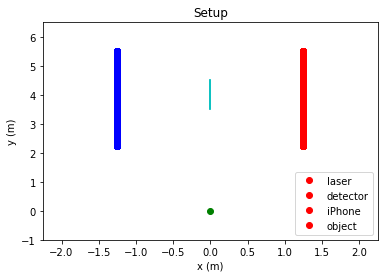

In [3]:
#####################################################################
################# GENERATE MULTIPLEXED MEASUREMENTS #################
#####################################################################
start = timer()

# hidden object location
# y_min = 0.75
# y_max = 1.25
x_min = 0
x_max = 0
y_min = 3.5
y_max = 4.5

# compute visibility matrix
vis_gt = computeVisibility(las_x, las_y, det_x, det_y, 0, y_min, y_max)
# vis_gt = np.where(np.random.rand(numPixels, numSpots) > 0.5, 1, 0)
# print(np.sum(vis_gt))

# compute multiplexed measurements
# observations, hists = generateData(las_x, las_y, det_x, det_y, vis_gt, numBins, 
#                                    plotData, plotSetup, x_min, x_max, y_min, y_max, usePulse, pctNoise, jitter, pulseWidth, t)
observations2, hists2 = generateDataFast(las_x, las_y, det_x, det_y, vis_gt, numBins, 
                                   plotData, plotSetup, x_min, x_max, y_min, y_max, usePulse, pctNoise, jitter, pulseWidth, t)

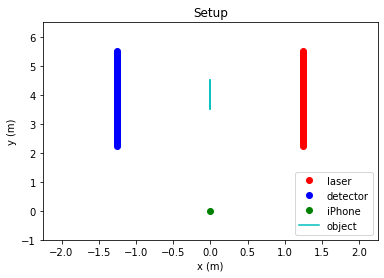

In [4]:
observations, hists = generateData(las_x, las_y, det_x, det_y, vis_gt, numBins, 
                                   plotData, plotSetup, x_min, x_max, y_min, y_max, usePulse, pctNoise, jitter, pulseWidth, t)

214 / 5625 entries in visibility matrix misclassified
3.8044444444444445% of entries in visibility matrix misclassified
201 ones flipped to zeros
93.92523364485982% of misclassified entries were ones flipped to zeros
23.738919334


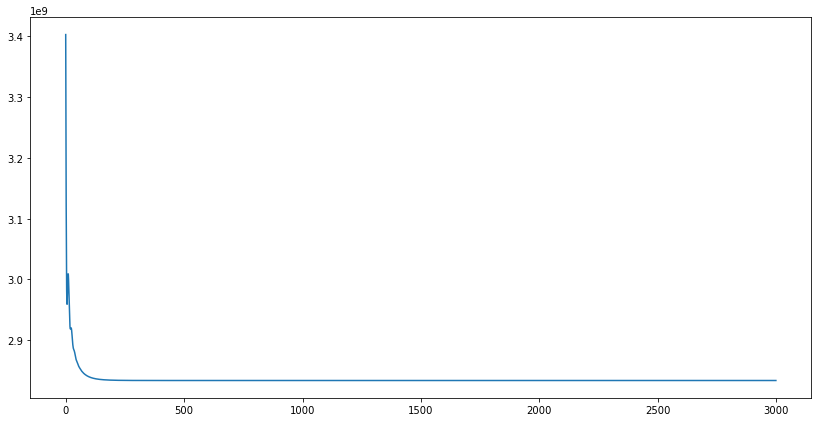

In [5]:
#####################################################################
####### SOLVE INVERSE PROBLEM (RECONSTRUCT VISIBILITY MATRIX) #######
#####################################################################
m = Model(numPixels, numSpots)
opt = torch.optim.Adam(m.parameters(), lr=lr_rate)
losses = training_loop(m, hists, observations, opt, thresh, lam, numIters)
vis = m.vis.detach()
# vis = (vis - np.min(vis)) / (np.max(vis) - np.min(vis))
vis = torch.sigmoid(vis)
v_reconst = torch.where(vis > 0.5, 1, 0).numpy()
# v_reconst = bruteForce(np.ones((numPixels, numSpots)), hists.detach().numpy(), observations.detach().numpy())

# plot optimization loss
if plotError:
    plt.figure(figsize=(14, 7))
    plt.plot(losses)

# compare ground truth visibility matrix
error = np.sum(np.abs(v_reconst-vis_gt))
pct_error = 100 * error / (numSpots * numPixels)
print(str(error) + ' / ' + str(numPixels*numSpots) + ' entries in visibility matrix misclassified')
print(str(pct_error) + '% of entries in visibility matrix misclassified')

onesToZero = np.sum(np.abs(v_reconst-vis_gt) * vis_gt)
print(str(onesToZero) + ' ones flipped to zeros')
print(str(100 * onesToZero / error) + '% of misclassified entries were ones flipped to zeros')
end = timer()
print(end - start)

In [6]:
def lossFunction(visGt, visRec, hist, obsGT, lamda):
    obs = np.sum(np.expand_dims(visRec, 2) * hist, 1)
    loss1 = np.mean((obsGT - obs)**2)
    print('Loss 1: ' + str(loss1))
    loss2 = np.sum(np.square(np.diff(visRec, n=1, axis=0)))
    print('Loss 2: ' + str(loss2))
    loss = loss1 + lamda * loss2
    print('Total Loss: ' + str(loss))
    return loss

loss_gt = lossFunction(vis_gt, vis_gt, hists.numpy(), observations.numpy(), lam)
loss_reconst = lossFunction(vis_gt, v_reconst, hists.numpy(), observations.numpy(), lam)

Loss 1: 2831592119.308271
Loss 2: 103
Total Loss: 2839832119.308271
Loss 1: 2828653943.6569533
Loss 2: 93
Total Loss: 2836093943.6569533


In [7]:
# obs = np.sum(np.expand_dims(v_reconst, 2) * hists.numpy(), 1)
# y1 = obs[61, :]
# y2 = observations.numpy()[61, :]
# y3 = y1-y2
# plt.plot(t, y1)
# plt.plot(t, y2)
# # plt.plot(t, y3)
# plt.legend(['reconst', 'gt'])

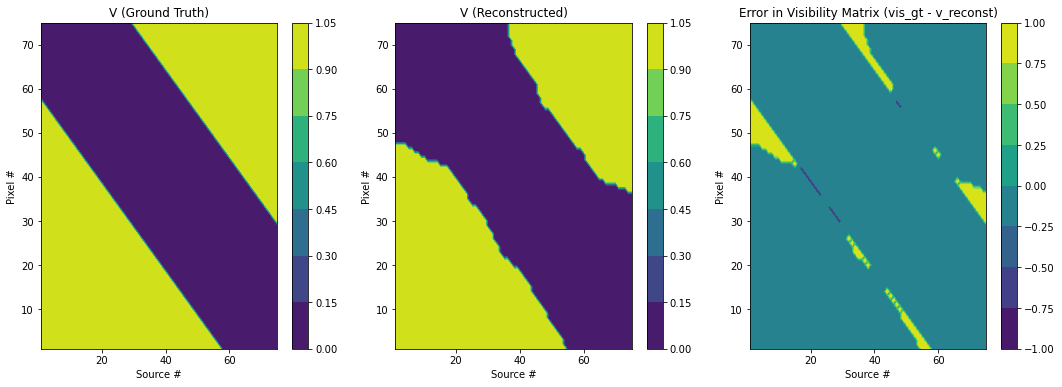

In [8]:
plt.figure(figsize=(18, 6))
x = np.linspace(1, numSpots, numSpots)
y = np.linspace(1, numPixels, numPixels)

plt.subplot(1, 3, 1)
plt.title('V (Ground Truth)')
plt.xlabel('Source #')
plt.ylabel('Pixel #')
plt.contourf(x, y, vis_gt)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('V (Reconstructed)')
plt.xlabel('Source #')
plt.ylabel('Pixel #')
plt.contourf(x, y, v_reconst)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('Error in Visibility Matrix (vis_gt - v_reconst)')
vis_errors = vis_gt - v_reconst
plt.xlabel('Source #')
plt.ylabel('Pixel #')
plt.contourf(x, y, vis_errors)
plt.colorbar()

In [9]:
testVar = np.sum(vis_gt, 1)
mask = (testVar == 58)
print(testVar * mask) # 12-70

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [10]:
testVar = 3
print('-'*60)
print('vis_errors')
print(vis_errors[testVar, :])
print('-'*60)
print('vis_gt')
print(vis_gt[testVar, :])
print('-'*60)
print('v_reconst')
print(v_reconst[testVar, :])

------------------------------------------------------------
vis_errors
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
------------------------------------------------------------
vis_gt
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
------------------------------------------------------------
v_reconst
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [11]:
# vis_bf = bruteForce(np.ones((numPixels, numSpots)), hists.detach().numpy(), observations.detach().numpy())

# print('-'*50)

# error = np.sum(np.abs(vis_bf-vis_gt))
# pct_error = 100 * error / (numSpots * numPixels)
# print(str(error) + ' / ' + str(numPixels*numSpots) + ' entries in visibility matrix misclassified')
# print(str(pct_error) + '% of entries in visibility matrix misclassified')
# print('-'*50)
# print('Original Reconstruction')
# print(v_reconst[:, testVar])
# print('-'*50)
# print('Fixed Reconstruction')
# print(vis_bf[:, testVar])
# print('-'*50)
# print('Bits need to be flipped')
# print(np.abs(vis_gt[:, testVar] - v_reconst[:, testVar]))
# print('new error: ' + str(np.sum(np.abs(vis_gt-vis_bf))))

In [12]:
# obs1 = np.sum(np.expand_dims(vis_gt, 2) * hists.numpy(), 1)
# loss1 = np.sum(np.abs(obs1 - observations.numpy()))
# obs2 = np.sum(np.expand_dims(vis_bf, 2) * hists.numpy(), 1)
# loss2 = np.sum(np.abs(obs1 - observations.numpy()))
# print(loss1 )
# print(loss2 )
# print(np.sum(np.abs(vis_gt - vis_bf)))

In [13]:
# print(np.abs(vis_gt - v_reconst) * vis_gt)
# print('-'*50)
# print(np.abs(vis_gt - v_reconst))
# print(vis_gt)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  6  6  0  0  0  0  0  0  0  0  6  7  7 10
  9  8  7  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  6  7]


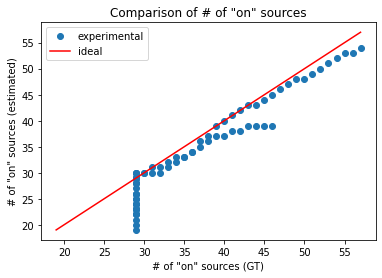

In [14]:
# plot for all entries
a = np.sum(vis_gt, 1)
b = np.sum(v_reconst, 1)
min_err = min(np.min(a), np.min(b))
max_err = max(np.max(a), np.max(b))
x = np.linspace(min_err, max_err); y = x
plt.figure()
plt.plot(a, b, 'o')
plt.plot(x, y, 'r')
plt.legend(['experimental', 'ideal'])
plt.xlabel('# of "on" sources (GT)')
plt.ylabel('# of "on" sources (estimated)')
plt.title('Comparison of # of "on" sources')
print(np.abs(a-b) * (np.abs(a-b) > 5))

In [15]:
mask1 = (a==58)
mask2 = (np.abs(a-b) != 0)
mask3 = mask1 * mask2
print(mask3 * (a-b))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


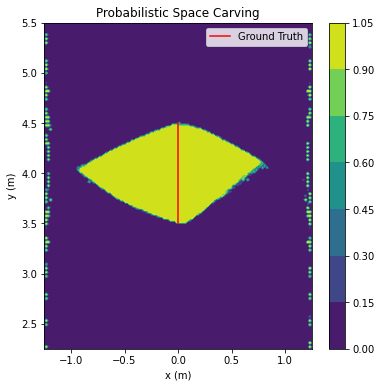

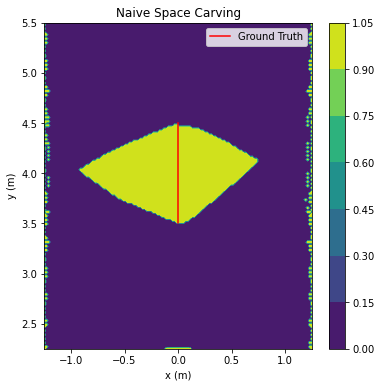

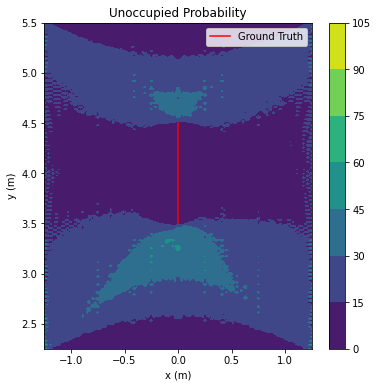

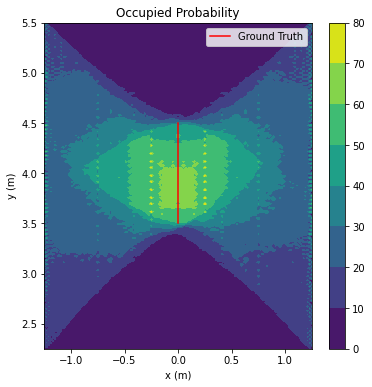

In [16]:
#####################################################################
#################### COMPUTE SHAPE USING CARVING ####################
#####################################################################

# carving parameters
pixelSize = 0.02# in meters
xMin = -1.25; xMax = 1.25
eta = 0.01; zeta = 0.85; p_e = 0.5; p_o = 0.5

# compute and plot heatmap
xlocs, ylocs, heatmap, naiveMap, occupied_prob, unoccupied_prob = carving(v_reconst, las_x, las_y, det_x, det_y, 
                                                                          pixelSize, xMin, xMax, eta, zeta, p_e, p_o)
heatmap_mod = heatmap * ((unoccupied_prob != 0 )| (occupied_prob != 0))

plt.figure(figsize=(6,6))
plt.title('Probabilistic Space Carving')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.contourf(xlocs, ylocs, heatmap_mod)
plt.plot(np.zeros(100), np.linspace(y_min, y_max, 100), 'r')
plt.legend(['Ground Truth'])
plt.colorbar()

plt.figure(figsize=(6,6))
plt.title('Naive Space Carving')
# plt.gray()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.contourf(xlocs, ylocs, naiveMap)
plt.plot(np.zeros(100), np.linspace(y_min, y_max, 100), 'r')
plt.legend(['Ground Truth'])
plt.colorbar()

plt.figure(figsize=(6,6))
plt.title('Unoccupied Probability')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.contourf(xlocs, ylocs, unoccupied_prob)
plt.plot(np.zeros(100), np.linspace(y_min, y_max, 100), 'r')
plt.legend(['Ground Truth'])
plt.colorbar()

plt.figure(figsize=(6,6))
plt.title('Occupied Probability')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.contourf(xlocs, ylocs, occupied_prob)
plt.plot(np.zeros(100), np.linspace(y_min, y_max, 100), 'r')
plt.legend(['Ground Truth'])
plt.colorbar()

pulse width: 0.5293031407464487 ns


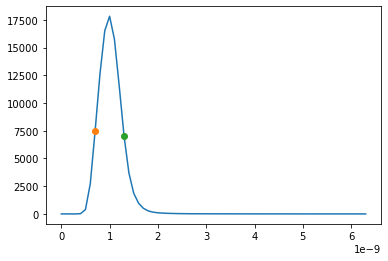

In [17]:
# calculate pulse width
t, a = pulse(0, 64)
plt.plot(t, a)
peaks, _ = find_peaks(a)
results_full = peak_widths(a, peaks, rel_height=0.5)
real_width = results_full[0][0] * 100E-12
left_idx, right_idx = results_full[2:]
left_idx2 = int(np.floor(left_idx[0])); right_idx2 = int(np.ceil(right_idx[0]))
plt.plot(t[left_idx2], a[left_idx2], 'o')
plt.plot(t[right_idx2], a[right_idx2], 'o')
print('pulse width: ' + str(real_width * 1E9) + ' ns')

[1e-10, 6e-10]


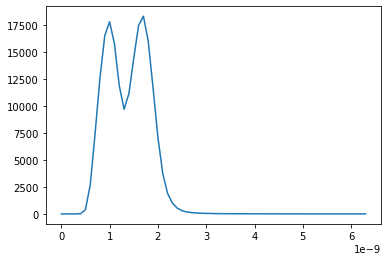

In [18]:
# debug
t, a = pulse(0, 64)
# t, b = pulse(7E-10, 64)
t, b = pulse(7E-10, 64)
c = a + b

plt.plot(t, c)
sig1 = c; sig2 = a

print(matchFilt(sig1, sig2))